In [1]:
from pathlib import Path
from PIL import Image
from bs4 import BeautifulSoup

In [2]:
xml = open(file='annotations/train_annot.xml')
xml_file = xml.read()

xml_file[:100]

'<?xml version="1.0" encoding="utf-8"?>\n<annotations>\n  <version>1.1</version>\n  <meta>\n    <task>\n  '

In [3]:
bs = BeautifulSoup(xml_file, 'lxml-xml')

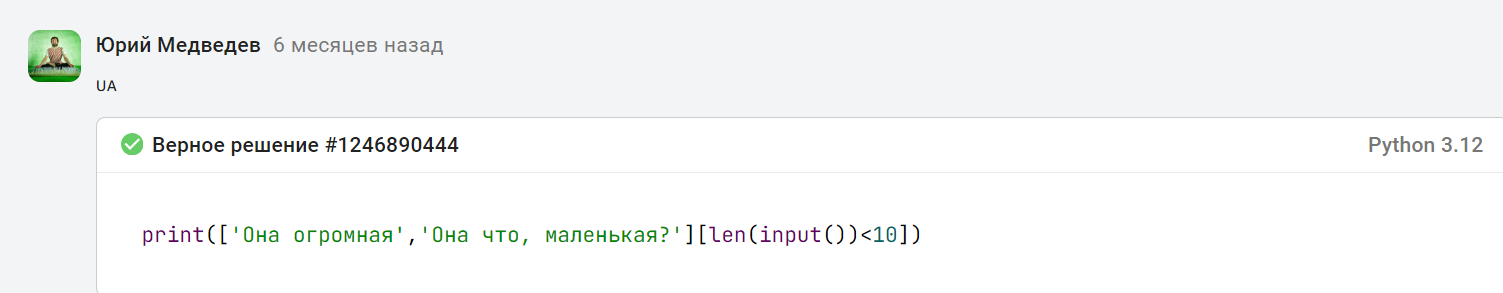

### Each image looks like

In [4]:
for image in bs.findAll('image'):
    print(image)
    break  # Returns only first image

<image height="2560" id="0" name="014de911-7810-4f7d-8967-3e5402209f4a.jpg" width="2560">
<box label="aircraft" occluded="0" source="manual" xbr="247.22" xtl="169.57" ybr="1555.35" ytl="1502.75" z_order="0">
</box>
<box label="aircraft" occluded="0" source="manual" xbr="285.72" xtl="222.23" ybr="1382.66" ytl="1338.77" z_order="0">
</box>
<box label="aircraft" occluded="0" source="manual" xbr="380.08" xtl="258.19" ybr="1863.09" ytl="1756.15" z_order="0">
</box>
<box label="aircraft" occluded="0" source="manual" xbr="1587.10" xtl="1505.39" ybr="2511.24" ytl="2459.55" z_order="0">
</box>
<box label="aircraft" occluded="0" source="manual" xbr="1534.97" xtl="1472.71" ybr="2191.55" ytl="2138.50" z_order="0">
</box>
<box label="aircraft" occluded="0" source="manual" xbr="1927.61" xtl="1862.87" ybr="1515.81" ytl="1438.89" z_order="0">
</box>
<box label="aircraft" occluded="0" source="manual" xbr="1526.16" xtl="1421.63" ybr="1556.20" ytl="1468.83" z_order="0">
</box>
<box label="aircraft" occlu

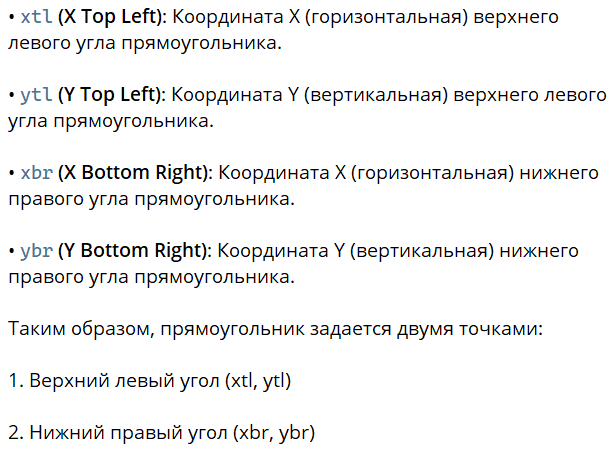

# Make parser for CVAT tasks

In [5]:
classes = ['aircraft', 'ship']
tasks = ['Train', 'Test']

In [6]:
def CVAT_task_parser(images_dir: str, annot_dir: str, save_dir: str):
    """
    This function parse images from CVAT tasks, then crop objects from images
    and save them in new directory

    Args:
        images_dir (str): The path store images with objects
        annot_dir (str): The path store annotations.xml for particular CVAT task
        save_dir (str): The path where cropped images will be stored
        
    Returns:
        None
    """
    pass

In [7]:
# Парсинг XML
xml_data = open('annotations/train_annot.xml').read()
soup = BeautifulSoup(xml_data, 'xml')

# Игнорируем версию и метаданные, переходим к аннотациям
for image in soup.find_all('image'):
    image_id = image['id']
    image_name = image['name']
    # print(f"Image ID: {image_id}, Name: {image_name}")

    # Обрабатываем аннотации (bounding boxes)
    for box in image.find_all('box'):
        label = box['label']
        xtl = box['xtl']
        ytl = box['ytl']
        xbr = box['xbr']
        ybr = box['ybr']
        # print(f"  Label: {label}, Coordinates: ({xtl}, {ytl}, {xbr}, {ybr})")

In [8]:
from tqdm import tqdm  # Для красивого прогресс-бара
from pathlib import Path
import cv2
from bs4 import BeautifulSoup


# Пути к папкам и файлам
train_folder = Path('Train')  # Папка с изображениями
annotations_file = Path('annotations/Train_annot.xml')  # Файл с аннотациями
output_folder = Path('Saved images')  # Папка для сохранения кропов

# Создаем папки для лейблов
(output_folder / 'ship').mkdir(parents=True, exist_ok=True)
(output_folder / 'aircraft').mkdir(parents=True, exist_ok=True)

# Парсим XML-файл с аннотациями
with open(annotations_file, 'r') as f:
    soup = BeautifulSoup(f, 'xml')

# Обрабатываем каждое изображение
for image in tqdm(soup.find_all('image'), desc="Processing images"):
    image_name = image['name']
    image_path = train_folder / image_name

    # Открываем изображение
    img = cv2.imread(str(image_path))  # Path нужно преобразовать в строку для OpenCV
    if img is None:
        print(f"Ошибка: изображение {image_name} не найдено.")
        continue

    # Обрабатываем каждый bounding box
    for box in image.find_all('box'):
        label = box['label']
        xtl = int(float(box['xtl']))  # Координаты bounding box
        ytl = int(float(box['ytl']))
        xbr = int(float(box['xbr']))
        ybr = int(float(box['ybr']))

        # Кроп изображения
        cropped_img = img[ytl:ybr, xtl:xbr]

        # Сохраняем кроп в папку с лейблом
        output_path = output_folder / label / f"{image_path.stem}_{xtl}_{ytl}_{xbr}_{ybr}.jpg"
        cv2.imwrite(str(output_path), cropped_img)  # Path нужно преобразовать в строку для OpenCV

print("Обработка завершена!")

Processing images: 100%|███████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 32.18it/s]

Обработка завершена!


# Parser by DeepSeek

In [9]:
from pathlib import Path
from typing import List, Optional

from bs4 import BeautifulSoup
from tqdm import tqdm
import cv2


class AnnotationProcessor:
    """
    A class to process annotations from an XML file, crop images based on bounding boxes,
    and save the cropped images to specified folders.

    Attributes:
        train_folder (Path): Path to the folder containing training images.
        annotations_file (Path): Path to the XML file containing annotations.
        output_folder (Path): Path to the folder where cropped images will be saved.
        labels (List[str]): List of labels for which folders will be created.
    """

    def __init__(self, train_folder: str, annotations_file: str, output_folder: str) -> None:
        """
        Initialize the AnnotationProcessor.

        Args:
            train_folder (str): Path to the folder containing training images.
            annotations_file (str): Path to the XML file containing annotations.
            output_folder (str): Path to the folder where cropped images will be saved.
        """
        self.train_folder = Path(train_folder)
        self.annotations_file = Path(annotations_file)
        self.output_folder = Path(output_folder)
        self.labels: List[str] = ['ship', 'aircraft']  # Labels for creating folders

    def create_output_folders(self) -> None:
        """
        Create output folders for each label if they do not already exist.
        """
        for label in self.labels:
            (self.output_folder / label).mkdir(parents=True, exist_ok=True)

    def parse_annotations(self) -> BeautifulSoup:
        """
        Parse the XML file containing annotations.

        Returns:
            BeautifulSoup: A BeautifulSoup object representing the parsed XML.
        """
        with open(self.annotations_file, 'r') as f:
            return BeautifulSoup(f, 'xml')

    def process_image(self, image: BeautifulSoup) -> None:
        """
        Process a single image, extract bounding boxes, and save cropped images.

        Args:
            image (BeautifulSoup): An <image> element from the parsed XML.
        """
        image_name: str = image['name']
        image_path: Path = self.train_folder / image_name

        # Open the image
        img: Optional[cv2.Mat] = cv2.imread(str(image_path))
        if img is None:
            print(f"Error: Image {image_name} not found.")
            return

        # Process each bounding box
        for box in image.find_all('box'):
            label: str = box['label']
            xtl: int = int(float(box['xtl']))  # Bounding box coordinates
            ytl: int = int(float(box['ytl']))
            xbr: int = int(float(box['xbr']))
            ybr: int = int(float(box['ybr']))

            # Crop the image
            cropped_img: cv2.Mat = img[ytl:ybr, xtl:xbr]

            # Save the cropped image to the label folder
            output_path: Path = self.output_folder / label / f"{image_path.stem}_{xtl}_{ytl}_{xbr}_{ybr}.jpg"
            cv2.imwrite(str(output_path), cropped_img)

    def process_all_images(self) -> None:
        """
        Process all images from the annotations file, crop them, and save the results.
        """
        soup: BeautifulSoup = self.parse_annotations()
        self.create_output_folders()

        # Process each image with a progress bar
        for image in tqdm(soup.find_all('image'), desc="Processing images"):
            self.process_image(image)

        print("Processing completed!")


# Example usage
if __name__ == "__main__":
    # Paths to folders and files
    train_folder: str = 'Train'
    annotations_file: str = 'annotations/Train_annot.xml'
    output_folder: str = 'Saved images'

    # Create an instance of the class and start processing
    processor: AnnotationProcessor = AnnotationProcessor(train_folder, annotations_file, output_folder)
    processor.process_all_images()

Processing images: 100%|███████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 35.16it/s]

Processing completed!


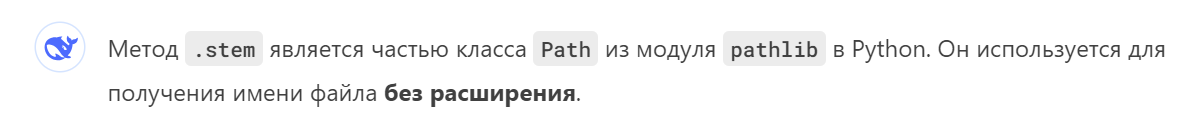

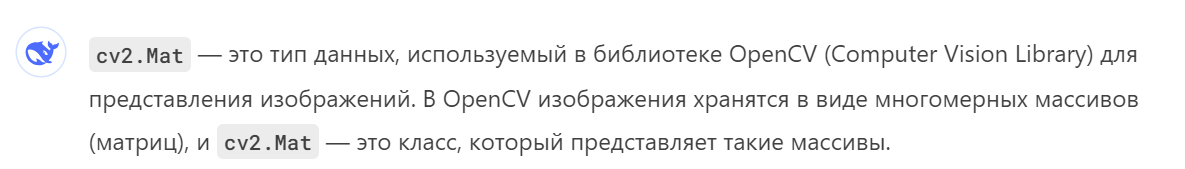

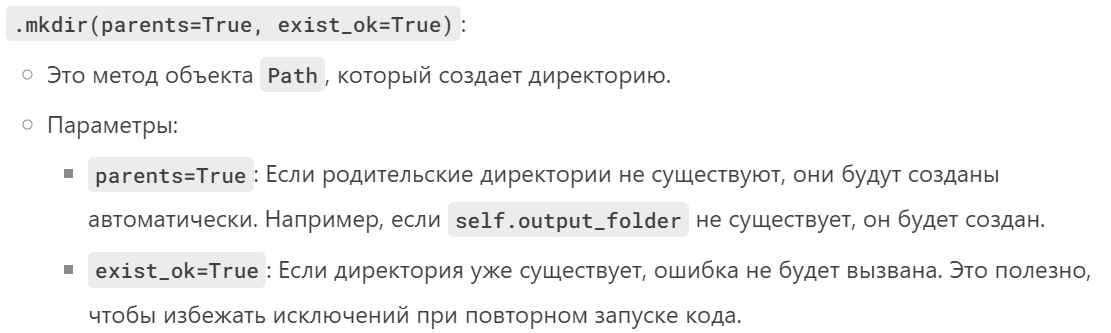

# Изучаю поэтапно что происходит

In [10]:
from pathlib import Path
import cv2
from bs4 import BeautifulSoup

In [11]:
train_folder = Path('Train')
annotations = Path('annotations/train_annot.xml')
output_folder = Path('cropped images')

In [12]:
train_folder

WindowsPath('Train')

In [13]:
with open(annotations) as file:
    soup = BeautifulSoup(file, 'xml')

In [14]:
(output_folder / 'ship').mkdir(parents=True, exist_ok=True)
(output_folder / 'aircraft').mkdir(parents=True, exist_ok=True)

In [15]:
for image in soup.find_all(name='image'):
    # print(image)
    image_name = image['name']
    # print(image_name)
    img = cv2.imread(str(train_folder / image_name))
    # print(img)
    
    for box in image.find_all(name='box'):
        # print(box)
        label = box['label']
        xbr = int(float(box['xbr']))
        xtl = int(float(box['xtl']))
        ybr = int(float(box['ybr']))
        ytl = int(float(box['ytl']))

        cropped_img = img[ytl:ybr, xtl:xbr]  # ytl:ybr, xtl:xbr

        # Сохраняем кроп в папку с лейблом
        output_path = output_folder / label / f"{image_name}_{xtl}_{ytl}_{xbr}_{ybr}.jpg"
        cv2.imwrite(str(output_path), cropped_img)  # Path нужно преобразовать в строку для OpenCV